In [1]:
import gc
import torch
import pandas as pd

from utils.plot import plot_result, plot_loss, get_legend_elements, DISEASE_CMAP
from models.load import TrainedModels, get_trained_model
from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS

from utils.init import reproducibility, clean_memory_get_device
from data.datasets import ReflacxDataset
from data.transforms import get_transform
from enum import Enum

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
# class TrainedModels(Enum):
#     custom_with_clinical_no_pretrained_ar = "val_ar_0_5220_ap_0_2513_test_ar_0_5590_ap_0_2442_epoch150_WithClincal_04-13-2022 20-13-47_custom_with_clinical_no_pretrained"
#     custom_with_clinical_no_pretrained_ap = "val_ar_0_4554_ap_0_2582_test_ar_0_5254_ap_0_2405_epoch139_WithClincal_04-13-2022 19-05-08_custom_with_clinical_no_pretrained"
#     custom_with_clinical_no_pretrained_final = "val_ar_0_4523_ap_0_2251_test_ar_0_5103_ap_0_2464_epoch200_WithClincal_04-14-2022 01-32-28_custom_with_clinical_no_pretrained"

#     custom_without_clinical_no_pretrained_ar = "val_ar_0_5645_ap_0_2659_test_ar_0_6263_ap_0_2533_epoch145_WithoutClincal_04-13-2022 08-47-34_custom_without_clinical_no_pretrained"
#     custom_without_clinical_no_pretrained_ap = "val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-28_custom_without_clinical_no_pretrained"
#     custom_without_clinical_no_pretrained_final = "val_ar_0_3757_ap_0_1699_test_ar_0_4421_ap_0_1819_epoch200_WithoutClincal_04-13-2022 14-58-52_custom_without_clinical_no_pretrained"

#     custom_without_clinical_swim_ap = "val_ar_0_5307_ap_0_2054_test_ar_0_5321_ap_0_1726_epoch87_WithoutClincal_04-17-2022 06-51-10_custom_without_clinical_swim"
#     custom_without_clinical_swim_ar = "val_ar_0_5313_ap_0_1540_test_ar_0_5906_ap_0_1486_epoch59_WithoutClincal_04-17-2022 05-48-30_custom_without_clinical_swim"
#     custom_without_clinical_swim_final = "val_ar_0_2175_ap_0_1390_test_ar_0_2231_ap_0_0901_epoch200_WithoutClincal_04-17-2022 10-49-59_custom_without_clinical_swim"

#     custom_with_clinical_swim_ap = "val_ar_0_5081_ap_0_2210_test_ar_0_5392_ap_0_1725_epoch95_WithClincal_04-17-2022 15-26-02_custom_with_clinical_swim"
#     custom_with_clinical_swim_ar = "val_ar_0_5377_ap_0_1821_test_ar_0_4561_ap_0_1193_epoch67_WithClincal_04-17-2022 14-02-28_custom_with_clinical_swim"
#     custom_with_clinical_swim_final = "val_ar_0_2752_ap_0_1293_test_ar_0_3391_ap_0_1097_epoch200_WithClincal_04-17-2022 20-31-24_custom_with_clinical_swim"


In [3]:
class TrainedModels(Enum):

    # custom_without_clinical_pretrained
    custom_without_clinical_pretrained_ar = "val_ar_0_5181_ap_0_2127_test_ar_0_5659_ap_0_2037_epoch36_WithoutClincal_04-10-2022 08-07-20_custom_without_clinical_pretrained"
    custom_without_clinical_pretrained_ap = "val_ar_0_4635_ap_0_2291_test_ar_0_5178_ap_0_1937_epoch17_WithoutClincal_04-10-2022 07-30-34_custom_without_clinical_pretrained"
    custom_without_clinical_pretrained_final = "val_ar_0_4279_ap_0_2052_test_ar_0_4103_ap_0_1757_epoch50_WithoutClincal_04-10-2022 08-34-20_custom_without_clinical_pretrained"

    # custom_with_clinical_pretrained
    custom_with_clinical_pretrained_ar = "val_ar_0_5171_ap_0_2336_test_ar_0_5267_ap_0_1545_epoch39_WithClincal_04-10-2022 10-15-22_custom_with_clinical_pretrained"
    custom_with_clinical_pretrained_ap = "val_ar_0_4581_ap_0_2496_test_ar_0_5533_ap_0_1655_epoch49_WithClincal_04-10-2022 10-38-54_custom_with_clinical_pretrained"
    custom_with_clinical_pretrained_final = "val_ar_0_3912_ap_0_1756_test_ar_0_5129_ap_0_1736_epoch50_WithClincal_04-10-2022 10-41-48_custom_with_clinical_pretrained"

In [4]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


## [Ajustable Section 1] Select the model you want to use.

In [11]:
select_model = TrainedModels.custom_with_clinical_pretrained_ap

## Which trained model to load is decided here.

In [12]:
model, train_info,_ = get_trained_model(select_model, DEFAULT_REFLACX_LABEL_COLS, device)
model.eval()
legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

Load custom model
Using ResNet50 as backbone
Using pretrained model


RuntimeError: Error(s) in loading state_dict for MultimodalMaskRCNN:
	Unexpected key(s) in state_dict: "clinical_expand_conv.22.weight", "clinical_expand_conv.22.bias", "clinical_expand_conv.23.weight", "clinical_expand_conv.23.bias". 

In [8]:
train_info.model_setup

ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=True, record_training_performance=False, dataset_mode='unified')

In [9]:
model

MultimodalMaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu

In [ ]:
plot_evaluator()

## Load dataste.

In [7]:
dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": train_info.model_setup.use_clinical,
    "dataset_mode": "unified",
    "bbox_to_mask": True,
}

# detect_eval_dataset = ReflacxDataset(
#     **{**dataset_params_dict, "dataset_mode": "unified",},
#     transforms=get_transform(train=False),
# )

detect_eval_dataset = ReflacxDataset(
    **{**dataset_params_dict, "dataset_mode": "unified",},
    transforms=get_transform(train=False),
)

## Load the tarining history to plot the loss curves and evaluation result for the loaded model.

### plot validation AP and AR

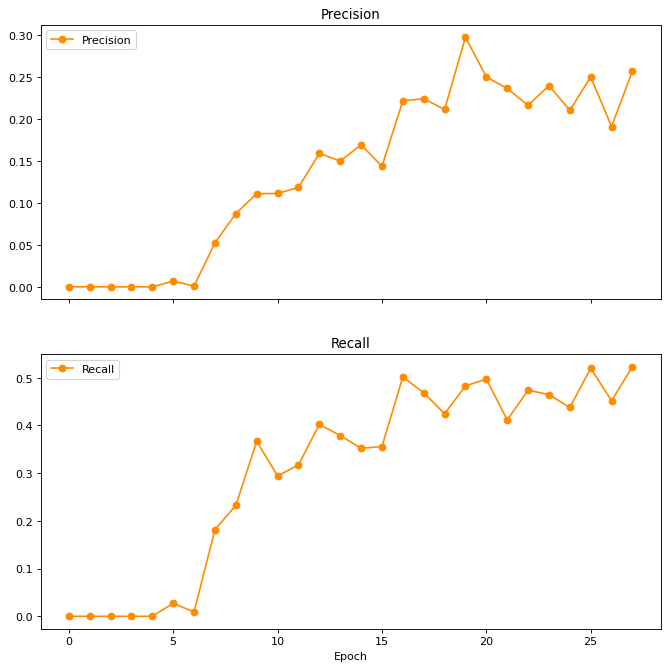

In [8]:
from utils.plot import plot_evaluator

_ = plot_evaluator(
    train_info.val_evaluators ,areaRng="all", iouThr=0.5, maxDets=10,
)


#### Plot loss curves.

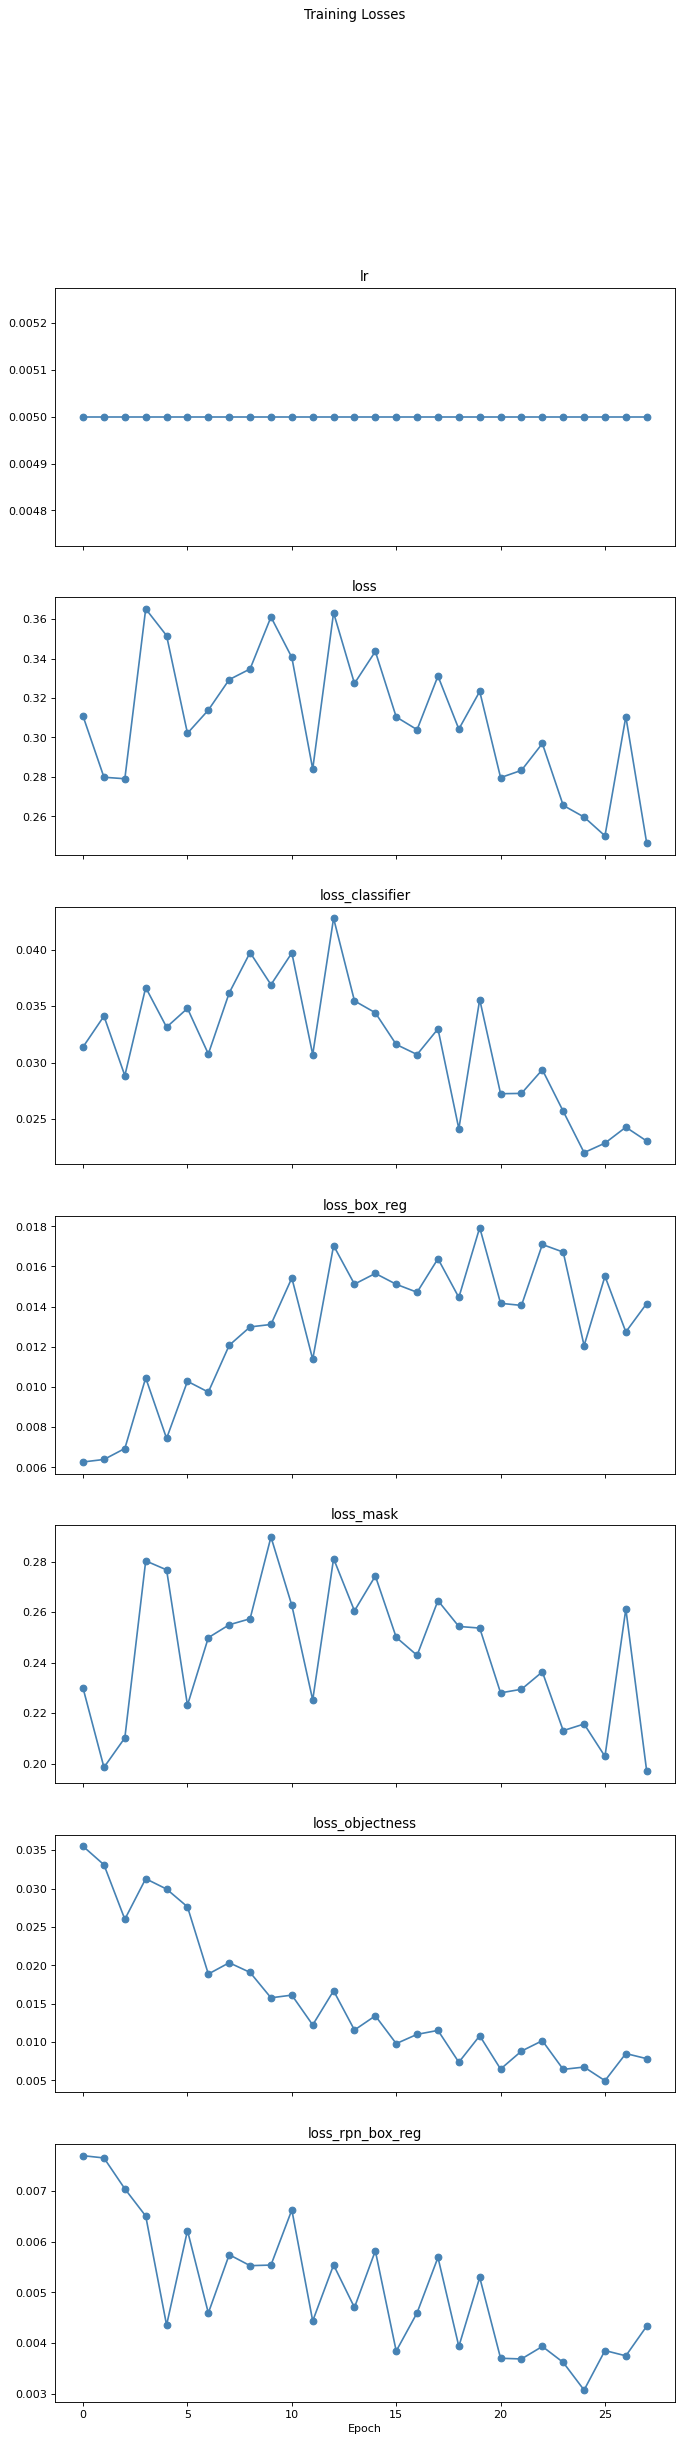

In [9]:
plot_loss(train_info.train_data)

#### print evaluation result.

In [10]:
train_info.test_evaluator.summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoBB=0.00:1.00 | area=   all | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ] = 0.255
 Average Precision  (AP) @[ IoBB=0.75      | area=   all | maxDets= 10 ] = 0.155
 Average Precision  (AP) @[ IoBB=0.00:1.00 | area= small | maxDets= 10 ] = -1.000
 Average Precision  (AP) @[ IoBB=0.00:1.00 | area=medium | maxDets= 10 ] = -1.000
 Average Precision  (AP) @[ IoBB=0.00:1.00 | area= large | maxDets= 10 ] = 0.214
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area=   all | maxDets=  1 ] = 0.421
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area=   all | maxDets=  6 ] = 0.513
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area=   all | maxDets= 10 ] = 0.513
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area= small | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area=medium | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoBB=0.00:1.00 | area= large | maxDets= 10 ] = 0.513
IoU met

## [Ajustable Section 2] Define the dicom_id you want to check. And, set the threshold for bounding boxes. 

In [11]:
dicom_id = '977eb09d-c5d88197-de0097d8-2a60dcb2-f3d335c8'

# Control score threshold for each class

In [12]:
model.roi_heads.score_thresh = 0.01 # initial threshold for all bounding boxes.

score_thres= {
    'Enlarged cardiac silhouette': 0.2,
    'Atelectasis': 0.2,
    'Pleural abnormality': 0.2,
    'Consolidation': 0.1,
    'Pulmonary edema': 0.05,
}

## Plot detections.

In [13]:
# [k for k , v in dict(detect_eval_dataset.df.dicom_id.value_counts()).items() if v >=5]

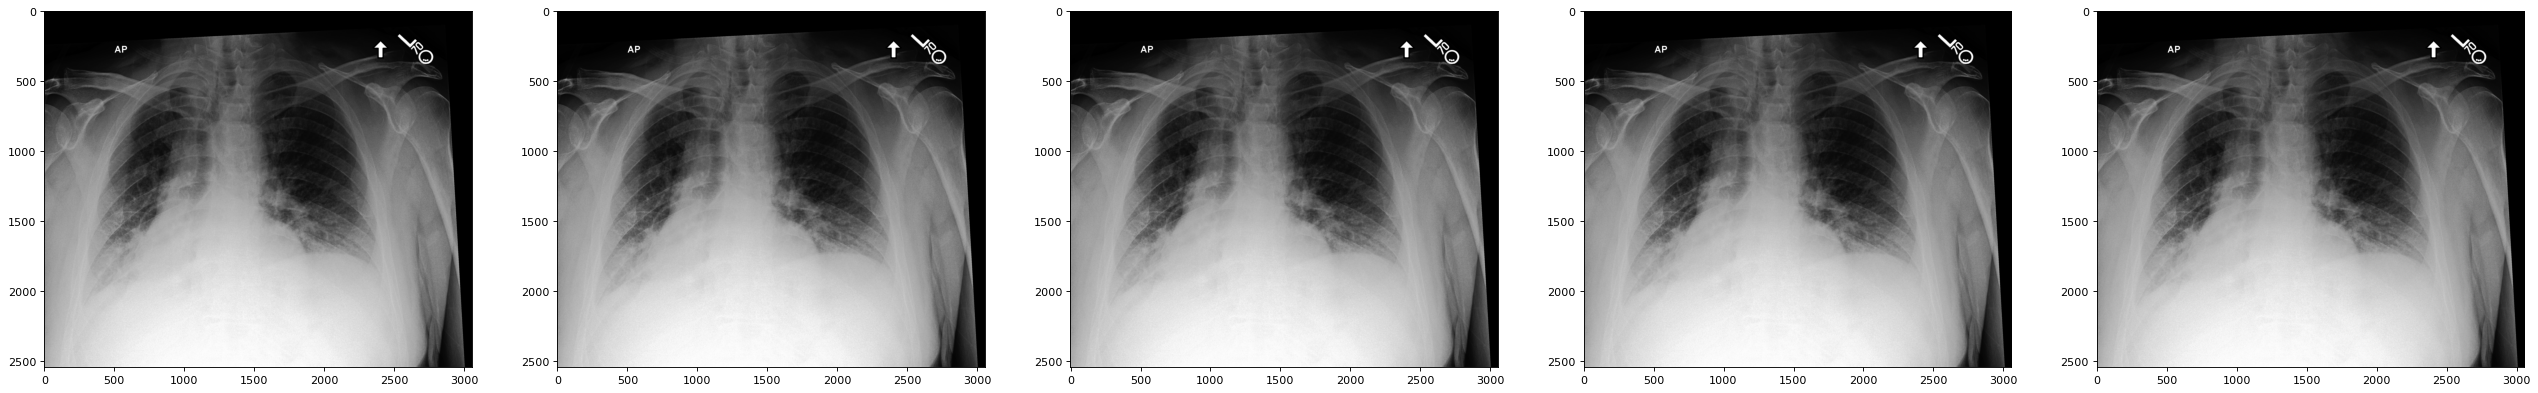

In [16]:
from data.dataset import collate_fn
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import PIL

dataset = detect_eval_dataset

for dicom_id in ['977eb09d-c5d88197-de0097d8-2a60dcb2-f3d335c8']:

    idxs = detect_eval_dataset.get_idxs_from_dicom_id(dicom_id)
    fig, axes = plt.subplots(1, len(idxs), figsize=(len(idxs)*8, 10), dpi=80, sharex=True)

    for i, idx in enumerate(idxs):
        data = collate_fn([dataset[idx]])
        data = dataset.prepare_input_from_data(data, device)
        target = data[-1][0]
        gt_recs = []
        # fig.suptitle(dicom_id)

        plot_ax = axes[i] if len(idxs) > 1 else axes

        img = PIL.Image.open(target["image_path"]).convert("RGB")
        plot_ax.imshow(img)

        # for label, bbox in zip(
        #         target["labels"].detach().cpu().numpy(), target["boxes"].detach().cpu().numpy()
        #     ):
        #     disease = detect_eval_dataset.label_idx_to_disease(label)
        #     c = disease_cmap['solid'][disease]
        #     gt_recs.append(
        #         Rectangle(
        #             (bbox[0], bbox[1]),
        #             bbox[2] - bbox[0],
        #             bbox[3] - bbox[1],
        #             fill=False,
        #             color=c,
        #             linewidth=2,
        #         )
        #     )
        #     plot_ax.text(bbox[0], bbox[1], disease, color="black", backgroundcolor=c)

        # for rec in gt_recs:
        #     plot_ax.add_patch(rec)

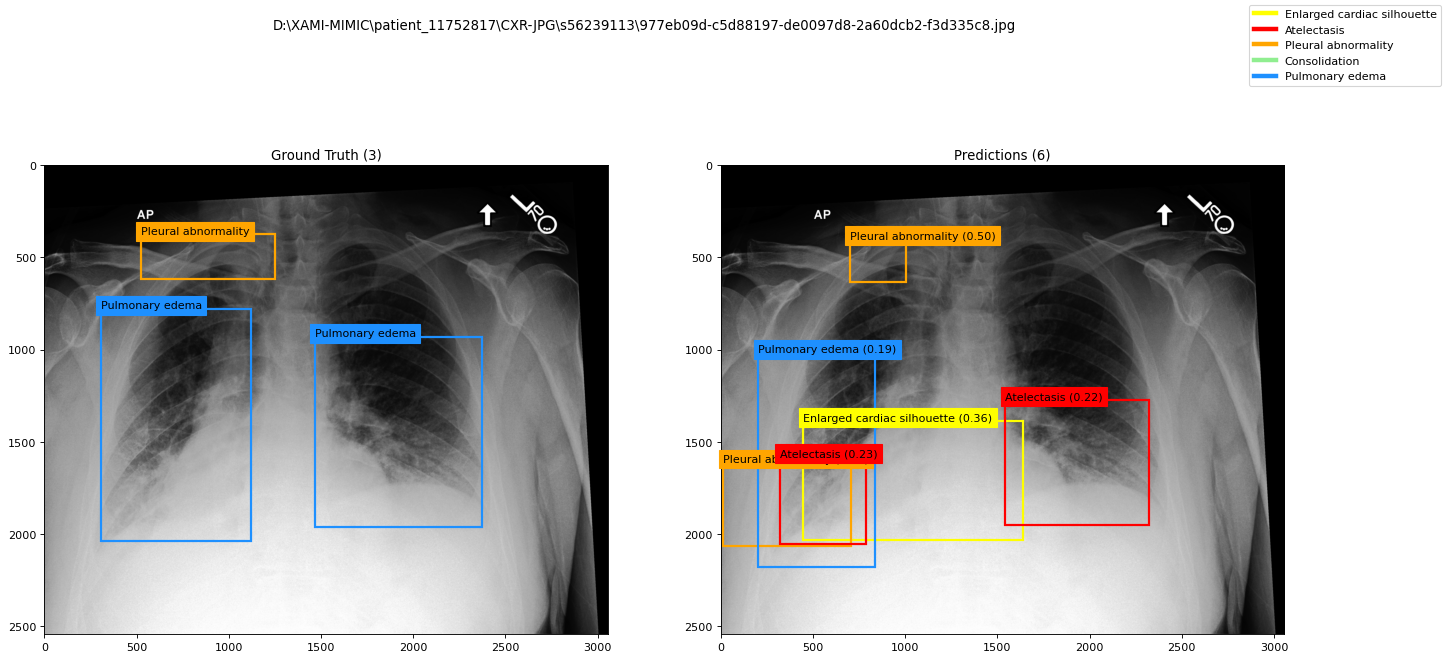

In [15]:
%matplotlib inline
idx= detect_eval_dataset.get_idxs_from_dicom_id(dicom_id)[0]

plot_result(
    model=model,
    dataset=detect_eval_dataset,
    device=device,
    idx= idx,
    legend_elements= legend_elements,
    disease_cmap =disease_cmap,
    seg=False,
    seg_thres=0.5,
    score_thres = score_thres,
)